### Hierarchical VI Example

In this example we will fit a hierarchical model to a simulated dataset using both MCMC and VI, and perform a simple comparison of the results.

Thanks for Guillaume Pagnier PhD for the initial version of this example.

In [1]:
import matplotlib
import numpy as np
import pandas as pd

matplotlib.use("Agg")
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
import pytensor

import hssm

warnings.filterwarnings("ignore")
# pytensor.config.floatX = "float64"

%matplotlib inline

### Utilities

In [2]:
def process_idata_for_plotting(
    idata: az.InferenceData, parameter_matrix: pd.DataFrame, model: str
) -> pd.DataFrame:
    """Process inference data and parameter matrix into a dataframe for plotting.

    Parameters
    ----------
    idata : az.InferenceData
        Inference data containing posterior samples
    parameter_matrix : pd.DataFrame
        DataFrame containing true parameter values
    model : str
        Name of model to get parameters for from defaults

    Returns
    -------
    pd.DataFrame
        DataFrame containing processed posterior means, HDIs and true parameters
        ready for plotting
    """
    # Get Posterior Means VI
    params_df_mean = pd.DataFrame(
        {
            param: idata.posterior[param].mean(dim=["chain", "draw"]).values
            for param in hssm.defaults.default_model_config[model]["list_params"]
        }
    )
    params_df_mean.columns = [f"{param}_mean" for param in params_df_mean.columns]

    # Get Posterior HDIs VI
    params_df_hdi = (
        az.hdi(
            idata.posterior[hssm.defaults.default_model_config[model]["list_params"]],
            hdi_prob=0.95,
        )
        .to_dataframe()
        .reset_index()
        .pivot(
            index="__obs__",
            columns="hdi",
            values=hssm.defaults.default_model_config[model]["list_params"],
        )
    )

    # Get rid of multiindex
    params_df_hdi.columns = ["_".join(col + ("hdi",)) for col in params_df_hdi.columns]
    params_df_hdi = params_df_hdi.reset_index(drop=True)

    # Combine data
    data_processed = pd.concat([simDataDDM, params_df_mean, params_df_hdi], axis=1)

    # Make plotting ready
    plot_df = pd.concat(
        [
            data_processed.drop(columns=["rt", "response"])
            .drop_duplicates()
            .reset_index(drop=True),
            parameter_matrix.drop(columns=["participant_id"]),
        ],
        axis=1,
    )
    return plot_df

### Simulate Dataset

We simulate a dataset of 20 participants, each with 120 trials.


In [3]:
# Group level parameters
v_mu = 0.2
v_sigma = 0.3
a_mu = 1
a_sigma = 0.2
z_mu = 0.5
z_sigma = 0.01
t_mu = 0.4
t_sigma = 0.00

# Make hierarchical dataset
parameter_matrix = pd.DataFrame(
    {
        "participant_id": [f"subj_{str(i).zfill(2)}" for i in range(1, 21)],
        "v_true": np.sort(np.random.normal(loc=v_mu, scale=v_sigma, size=20)).round(1),
        "a_true": np.sort(np.random.normal(loc=a_mu, scale=a_sigma, size=20)).round(1),
        "z_true": np.sort(np.random.normal(loc=z_mu, scale=z_sigma, size=20)).round(1),
        "t_true": np.sort(np.random.normal(loc=t_mu, scale=t_sigma, size=20)).round(1),
        "nTrials": [120] * 20,
    }
)


dfs = []
for _, row in parameter_matrix.iterrows():
    df = hssm.simulate_data(
        model="ddm",
        theta=dict(v=row["v_true"], a=row["a_true"], z=row["z_true"], t=row["t_true"]),
        size=row["nTrials"],
    )
    df["participant_id"] = row["participant_id"]
    dfs.append(df)
    simDataDDM = pd.concat(dfs, ignore_index=True)

## Hierarchical Model: Centered Parameterization

We first instantiate the generative model using HSSM syntax. We will fit this model to the synthetic data using two approaches 1. Variational inference 2. MCMC

In [4]:
# Generative model
mSimCentered = hssm.HSSM(
    data=simDataDDM,
    p_outlier=0.01,
    prior_settings="safe",
    noncentered=False,
    model="ddm",
    loglik_kind="approx_differentiable",
    include=[
        {
            "name": "v",
            "formula": "v ~ 0 +(1|participant_id)",
            "prior": {
                "1|id": {
                    "name": "Normal",
                    "mu": {
                        "name": "Normal",
                        "mu": 1.3,
                        "sigma": 0.3,
                    },
                    "sigma": {"name": "HalfNormal", "sigma": 0.2},
                },
            },
        },
        {
            "name": "a",
            "formula": "a ~ 0 + (1|participant_id)",
            "prior": {
                "1|id": {
                    "name": "Normal",
                    "mu": {"name": "Gamma", "mu": 1, "sigma": 0.2},
                    "sigma": {"name": "HalfNormal", "sigma": 0.2},
                },
            },
        },
        {
            "name": "z",
            "formula": "z ~ 0 + (1|participant_id)",
            "prior": {
                "1|id": {
                    "name": "Normal",
                    "mu": {"name": "Beta", "alpha": 10, "beta": 10},
                    "sigma": {"name": "HalfNormal", "sigma": 0.01},
                },
            },
        },
        {
            "name": "t",
            "formula": "t ~ 0 + (1|participant_id)",
            "prior": {
                "1|id": {
                    "name": "Normal",
                    "mu": {
                        "name": "Normal",
                        "mu": 0.4,
                        "sigma": 0.1,
                    },
                    "sigma": {"name": "HalfNormal", "sigma": 0.01},
                },
            },
        },
    ],
)

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter a is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter z is not applied due to a current limitation of Bambi. This will change in the future.
No common intercept. Bounds for parameter t is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


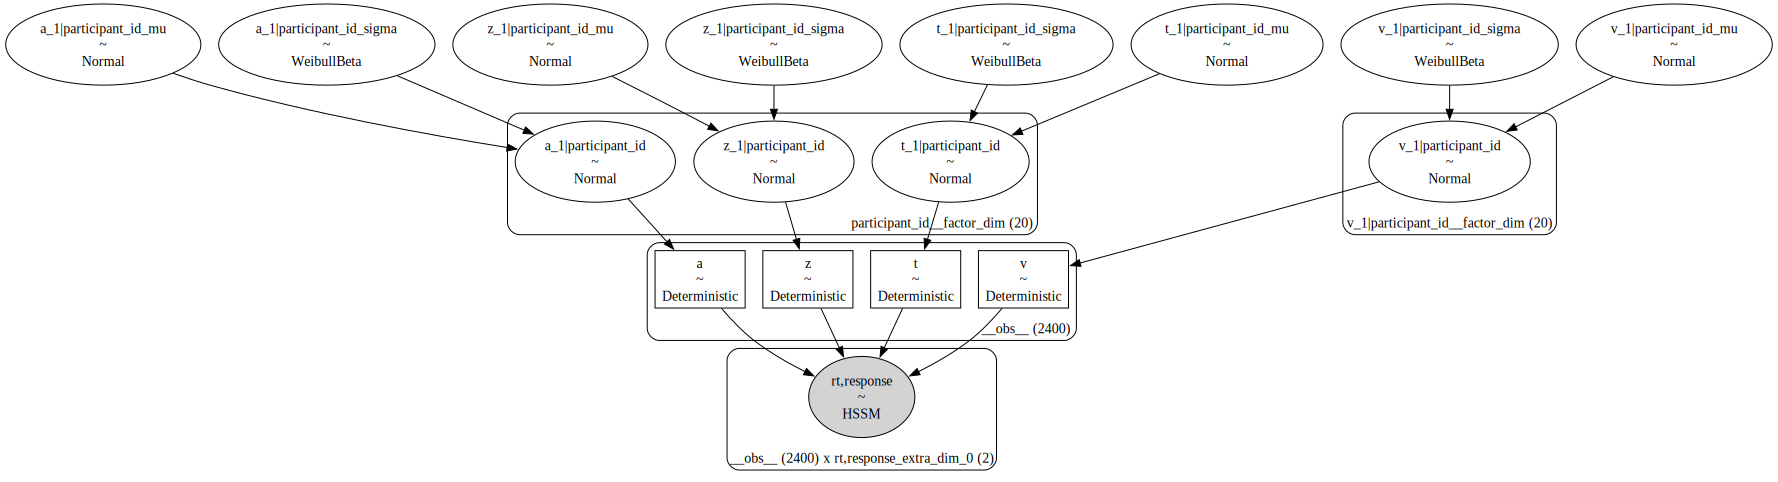

In [5]:
mSimCentered.graph()

### Fit VI

Approach 1: Using Variational Inference (VI) to estimate posteriors. VI is deterministic, it treats inference as an optimization problem. While typically faster then MCMC, it can underestimate true posterior variance and may not correctly consider the tradeoffs that may exist between parameters. Be sure to always use method "fullrank_advi".  

In [6]:
# VI
# obj_optimizer=pm.adamax(learning_rate=0.1)
vi_idata = mSimCentered.vi(
    niter=20000,
    method="advi",  # mention full_rank_advi
    obj_optimizer=pm.adamax(learning_rate=0.01),
)
mSimCenteredVIObject = mSimCentered.vi_approx.sample(draws=1000)

Using MCMC starting point defaults.


Output()

Finished [100%]: Average Loss = 3,636.8


Before looking at the posteriors we must ensure that the model successfully "converged".

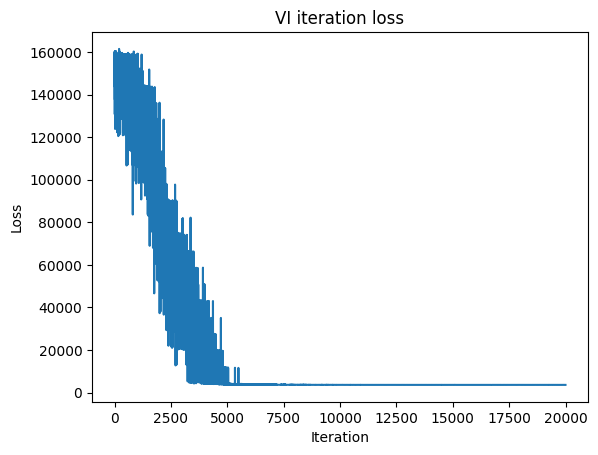

In [7]:
# Loss plot
plt.plot(mSimCentered.vi_approx.hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("VI iteration loss")
plt.show()

Once we are satisfied the loss is acceptable, we can take a look at the mean of the group parameters. These should match our generative parameters above.

In [8]:
summary_vi = az.summary(
    mSimCenteredVIObject.posterior,
    var_names=[r".*_mu", r".*_sigma"],
    filter_vars="regex",
).sort_index()
summary_vi

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_1|participant_id_mu,0.955,0.033,0.888,1.011,0.001,0.001,946.0,975.0,NaN
a_1|participant_id_sigma,0.152,0.024,0.109,0.201,0.001,0.001,1016.0,820.0,NaN
t_1|participant_id_mu,0.411,0.004,0.403,0.419,0.000,0.000,982.0,944.0,NaN
t_1|participant_id_sigma,0.020,0.003,0.014,0.027,0.000,0.000,940.0,951.0,NaN
v_1|participant_id_mu,0.171,0.052,0.086,0.281,0.002,0.001,864.0,786.0,NaN
v_1|participant_id_sigma,0.234,0.040,0.160,0.305,0.001,0.001,1007.0,909.0,NaN
z_1|participant_id_mu,0.489,0.004,0.482,0.497,0.000,0.000,895.0,931.0,NaN
z_1|participant_id_sigma,0.020,0.003,0.014,0.027,0.000,0.000,999.0,983.0,NaN


### Fit MCMC

Approach 2: Using MCMC to estimate posteriors. MCMC is typically slower than VI, but can more accurately capture the true posterior variance in some cases.


In [9]:
# MCMC
mSimCenteredSampled = mSimCentered.sample(
    sampler="nuts_numpyro", cores=4, chains=4, draws=250, tune=750, mp_ctx="forkserver"
)

mSimCentered.sample_posterior_predictive(idata=mSimCenteredSampled)

Using default initvals. 



sample: 100%|██████████| 1000/1000 [02:04<00:00,  8.05it/s, 31 steps of size 9.94e-02. acc. prob=0.92] 
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 1000/1000 [00:01<00:00, 509.90it/s]


Let's make sure MCMC converged and can successfully recapitulate the raw data

At an individual level, our model can capture the real data relatively well. How do the summary statistics of the posteriors compare to when we fit using VI?

In [10]:
summary_mcmc = az.summary(
    mSimCenteredSampled, var_names=[r".*_mu", r".*_sigma"], filter_vars="regex"
).sort_index()
summary_mcmc

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_1|participant_id_mu,0.950,0.037,0.882,1.013,0.001,0.001,786.0,726.0,1.01
a_1|participant_id_sigma,0.152,0.028,0.108,0.207,0.001,0.001,970.0,634.0,1.01
t_1|participant_id_mu,0.412,0.007,0.398,0.423,0.000,0.000,402.0,596.0,1.00
t_1|participant_id_sigma,0.015,0.007,0.003,0.028,0.001,0.000,87.0,141.0,1.05
v_1|participant_id_mu,0.170,0.061,0.047,0.274,0.002,0.002,819.0,868.0,1.01
v_1|participant_id_sigma,0.235,0.048,0.162,0.333,0.002,0.002,789.0,707.0,1.00
z_1|participant_id_mu,0.491,0.008,0.477,0.507,0.001,0.000,232.0,420.0,1.02
z_1|participant_id_sigma,0.014,0.007,0.003,0.026,0.001,0.000,57.0,81.0,1.06


### Process results for plotting

In [11]:
# Add trialwise parameters to idata
mSimCenteredSampled = mSimCentered.add_likelihood_parameters_to_idata(
    mSimCenteredSampled
)

plot_df_mcmc = process_idata_for_plotting(
    idata=mSimCenteredSampled, parameter_matrix=parameter_matrix, model="ddm"
)

plot_df_vi = process_idata_for_plotting(
    idata=mSimCenteredVIObject, parameter_matrix=parameter_matrix, model="ddm"
)

### Plotting

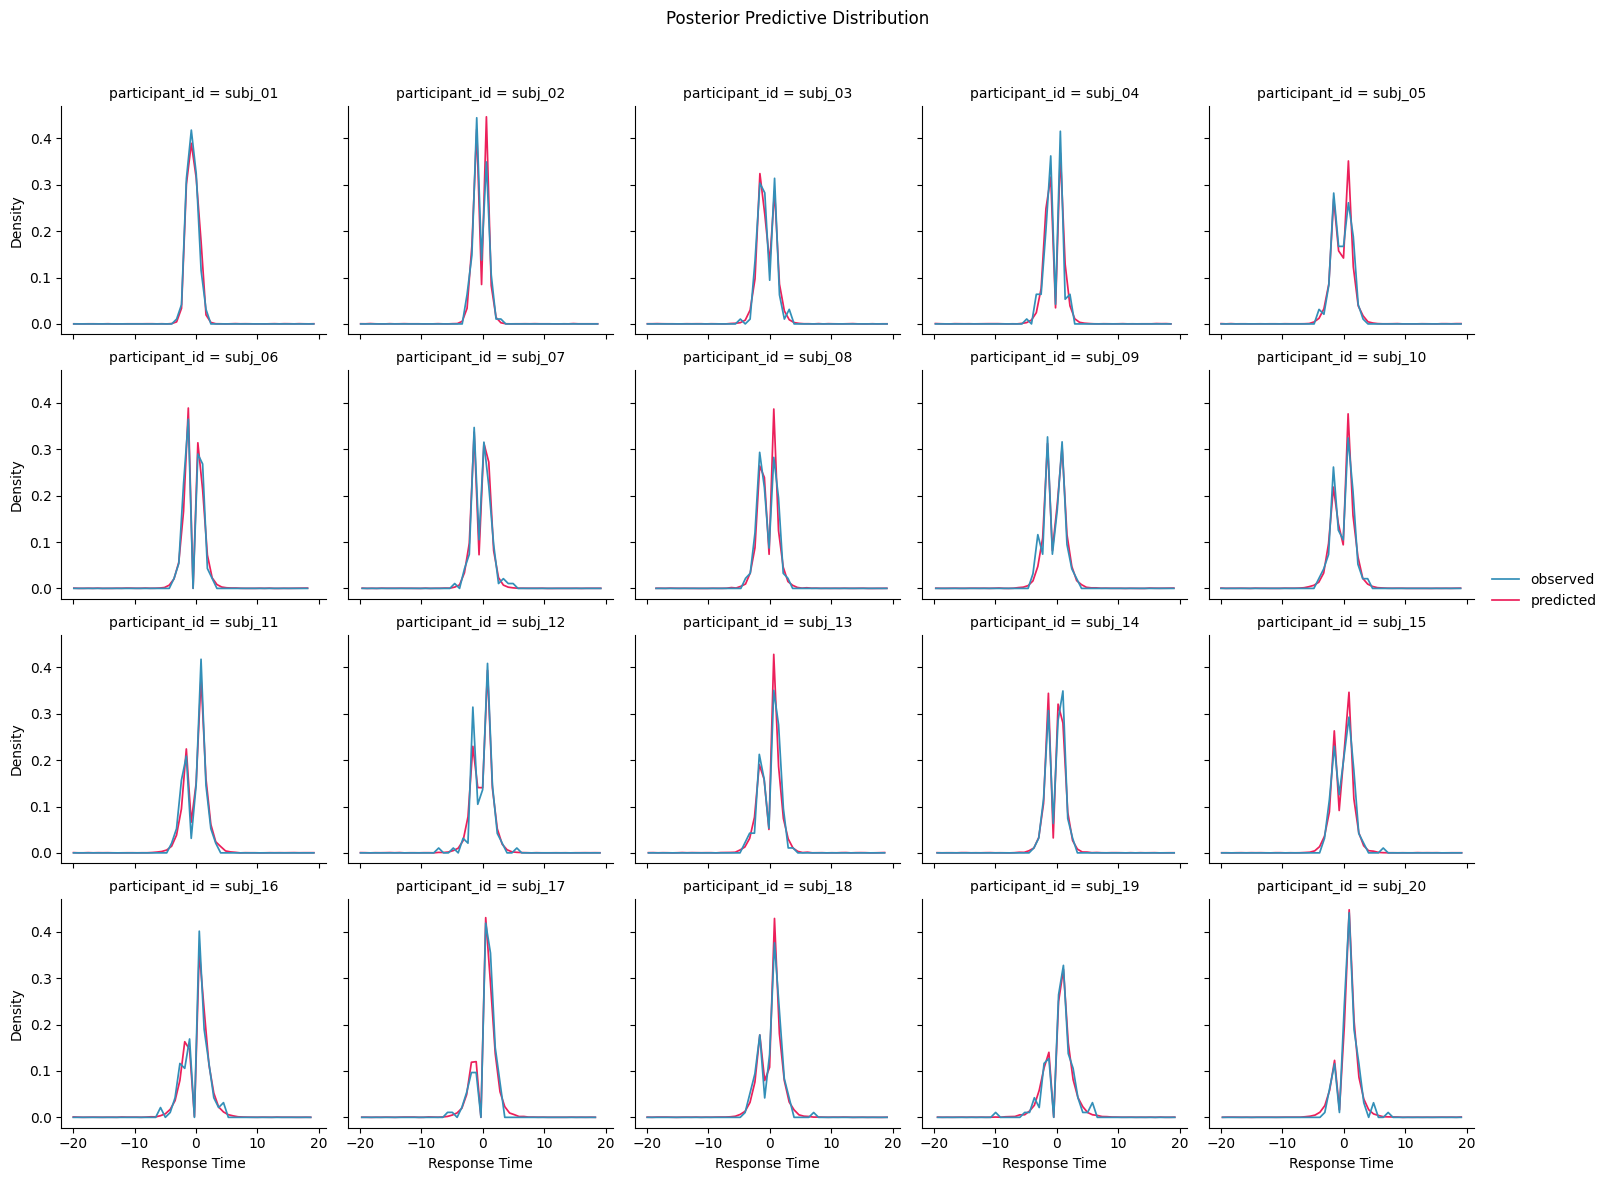

In [12]:
hssm.plotting.plot_posterior_predictive(mSimCentered, col="participant_id", col_wrap=5)

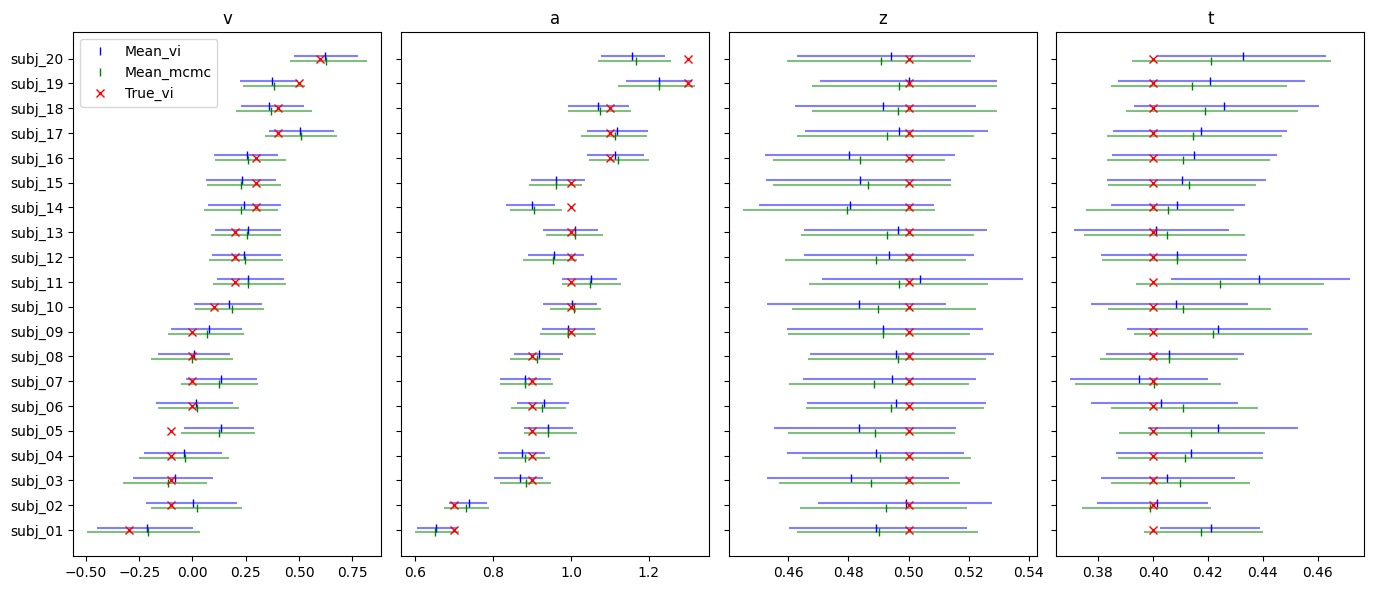

In [13]:
# Suppose your dataframe is called `df`
params = hssm.defaults.default_model_config["ddm"]["list_params"]
fig, axes = plt.subplots(nrows=1, ncols=len(params), figsize=(14, 6), sharey=True)

for ax, par in zip(axes, params):
    # Identify the relevant columns for this parameter
    mean_col = f"{par}_mean"
    lower_col = f"{par}_lower_hdi"
    upper_col = f"{par}_higher_hdi"
    true_col = f"{par}_true"  # if you also want to plot 'true' values

    # Sort if you want the participants in order on the y‐axis
    df_sorted_vi = plot_df_vi.sort_values("participant_id")
    df_sorted_mcmc = plot_df_mcmc.sort_values("participant_id")

    # We'll use the row index (0..N-1) for plotting against x=mean
    yvals = np.array(range(len(df_sorted_vi)))
    yvals_vi = yvals + 0.1
    yvals_mcmc = yvals - 0.1

    # Draw horizontal lines from lower_HDI to upper_HDI
    ax.hlines(
        yvals_vi,
        df_sorted_vi[lower_col],
        df_sorted_vi[upper_col],
        color="blue",
        alpha=0.5,
    )

    ax.hlines(
        yvals_mcmc,
        df_sorted_mcmc[lower_col],
        df_sorted_mcmc[upper_col],
        color="green",
        alpha=0.5,
    )

    # Mark the posterior mean in blue
    ax.plot(
        df_sorted_vi[mean_col],
        yvals_vi,
        "|",
        color="blue",
        label="Mean_vi" if par == "v" else None,
    )
    ax.plot(
        df_sorted_mcmc[mean_col],
        yvals_mcmc,
        "|",
        color="green",
        label="Mean_mcmc" if par == "v" else None,
    )

    # Optionally, if you have true values, plot them as red 'x'
    if true_col in df_sorted_vi.columns:
        ax.plot(
            df_sorted_vi[true_col],
            yvals,
            "x",
            color="red",
            label="True_vi" if par == "v" else None,
        )

    ax.set_title(par)
    ax.set_yticks(yvals)
    ax.set_yticklabels(df_sorted_vi["participant_id"])
    ax.invert_yaxis()  # optional, if you prefer subject_01 at the top
    if par == "v":
        ax.legend()

plt.tight_layout()
plt.show()

Here, results match up quite nicely between the two approaches. Overall the posteriors are very similar, and we don't see a strong tendency for VI posteriors to be more peaked than MCMC posteriors. 
However this is just an example, and we can't deduce a general rule from this observation.

## Hierarchical Model: Non-Centered Parameterization


To highlight that once we have the trial wise parameters, we can easily generate subject (and/or condition) wise plots of the posteriors,
we also show an example using the non-centered parameterization.

The non-centered parameterization is slightly more complex, so manually recomposing parameters can sometimes be a little bit more confusing.

We can let HSSM handle this via Bambi under the hood, and not worry about this complexity.

In [14]:
# Generative model
mSimNonCentered = hssm.HSSM(
    data=simDataDDM,
    p_outlier=0.01,
    prior_settings="safe",
    noncentered=True,
    model="ddm",
    loglik_kind="approx_differentiable",
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + (1|participant_id)",
        },
        {
            "name": "a",
            "formula": "a ~ 1 + (1|participant_id)",
        },
        {
            "name": "z",
            "formula": "z ~ 1 + (1|participant_id)",
        },
        {
            "name": "t",
            "formula": "t ~ 1 + (1|participant_id)",
        },
    ],
)

Model initialized successfully.


### Fit VI

In [15]:
# VI
# obj_optimizer=pm.adamax(learning_rate=0.1)
vi_idata_NC = mSimNonCentered.vi(
    niter=30000,
    method="advi",  # mention full_rank_advi
    obj_optimizer=pm.adamax(learning_rate=0.01),
)
mSimNonCenteredVIObject = mSimNonCentered.vi_approx.sample(draws=1000)

Using MCMC starting point defaults.


Output()

Finished [100%]: Average Loss = 3,627.5


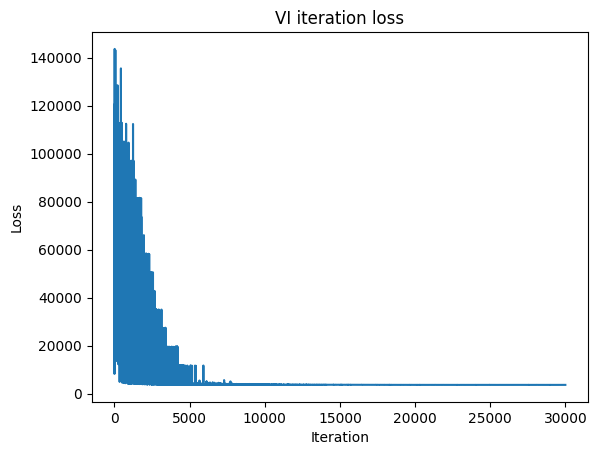

In [16]:
# Loss plot
plt.plot(mSimNonCentered.vi_approx.hist)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("VI iteration loss")
plt.show()

### Fit MCMC

In [17]:
# MCMC
mSimNonCenteredSampled = mSimNonCentered.sample(
    sampler="nuts_numpyro",
    cores=4,
    chains=4,
    draws=250,
    tune=750,
    mp_ctx="forkserver",
    nuts_kwargs={"max_tree_depth": 5},
)

mSimNonCentered.sample_posterior_predictive(idata=mSimNonCenteredSampled)

Using default initvals. 



sample: 100%|██████████| 1000/1000 [02:57<00:00,  5.62it/s, 31 steps of size 1.69e-01. acc. prob=0.90] 
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
100%|██████████| 1000/1000 [00:02<00:00, 493.37it/s]


### Post-process VI / MCMC results

In [18]:
mSimNonCenteredSampled = mSimNonCentered.add_likelihood_parameters_to_idata(
    mSimNonCenteredSampled
)

plot_df_vi_nc = process_idata_for_plotting(
    idata=mSimNonCenteredVIObject, parameter_matrix=parameter_matrix, model="ddm"
)

plot_df_mcmc_nc = process_idata_for_plotting(
    idata=mSimNonCenteredSampled, parameter_matrix=parameter_matrix, model="ddm"
)

### Plotting

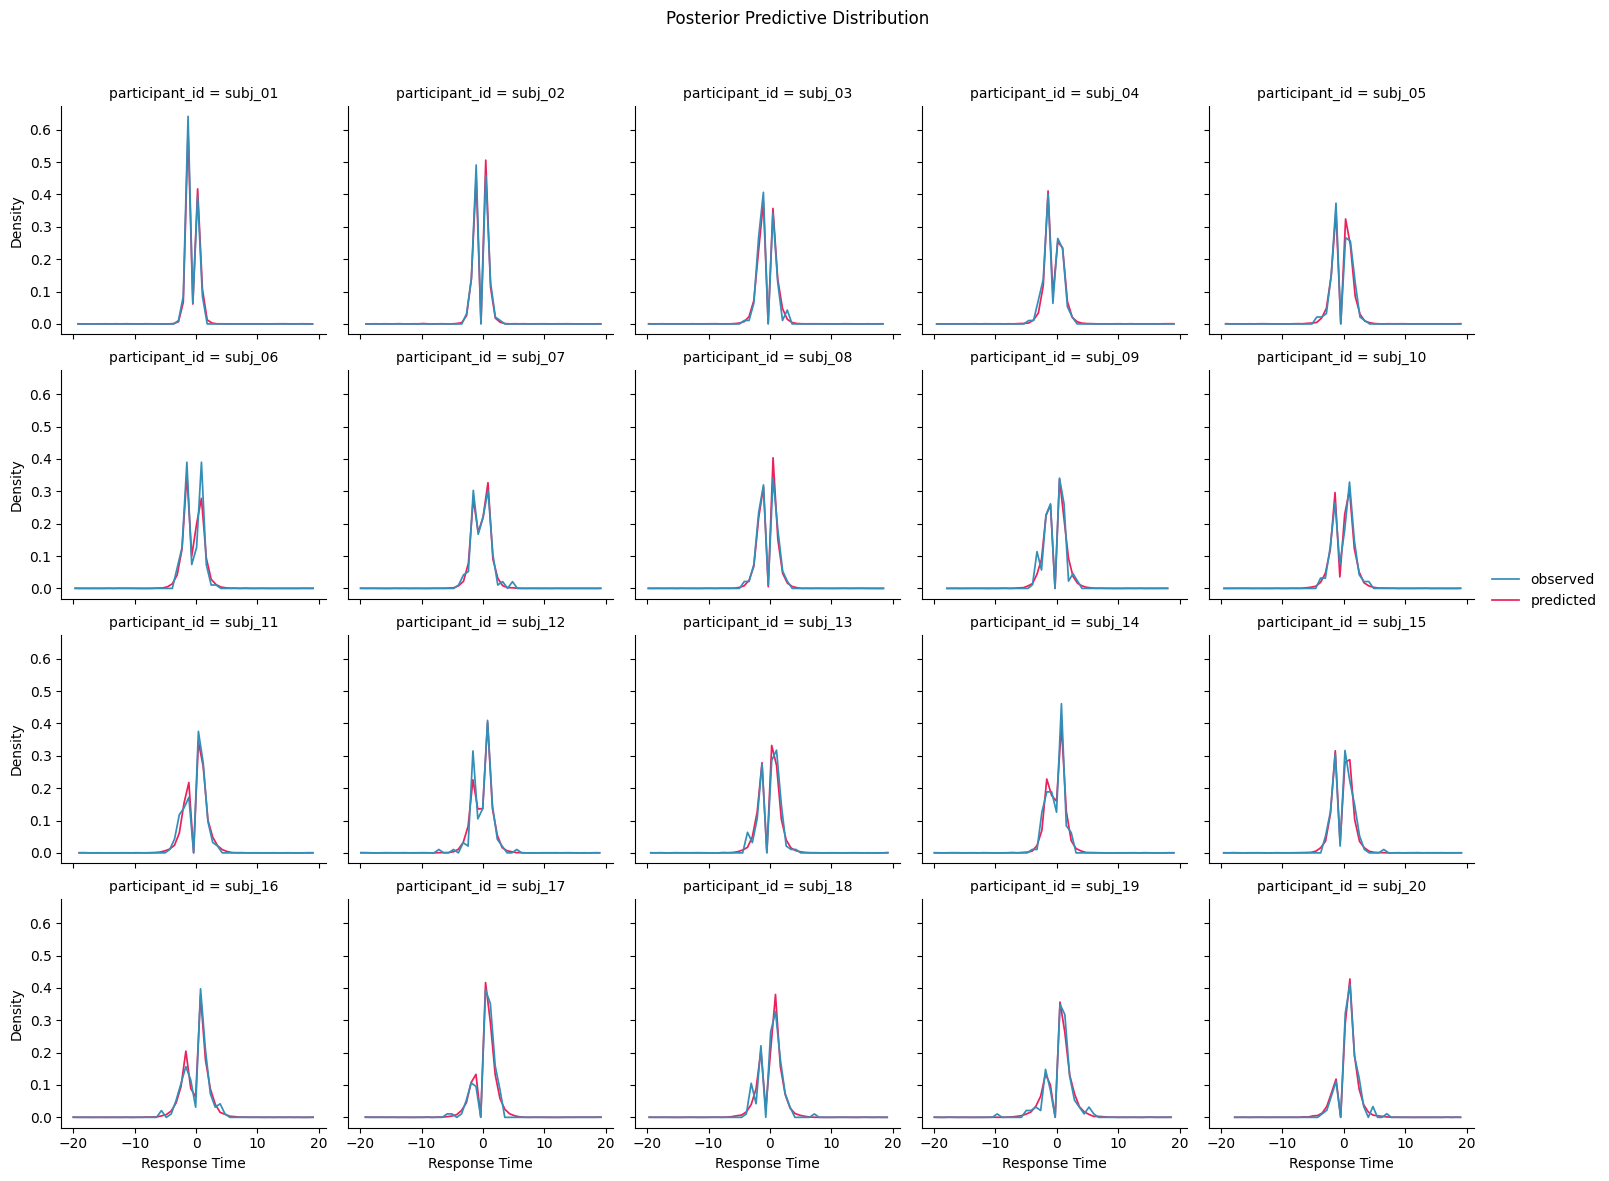

In [19]:
hssm.plotting.plot_posterior_predictive(
    mSimNonCentered, col="participant_id", col_wrap=5
)

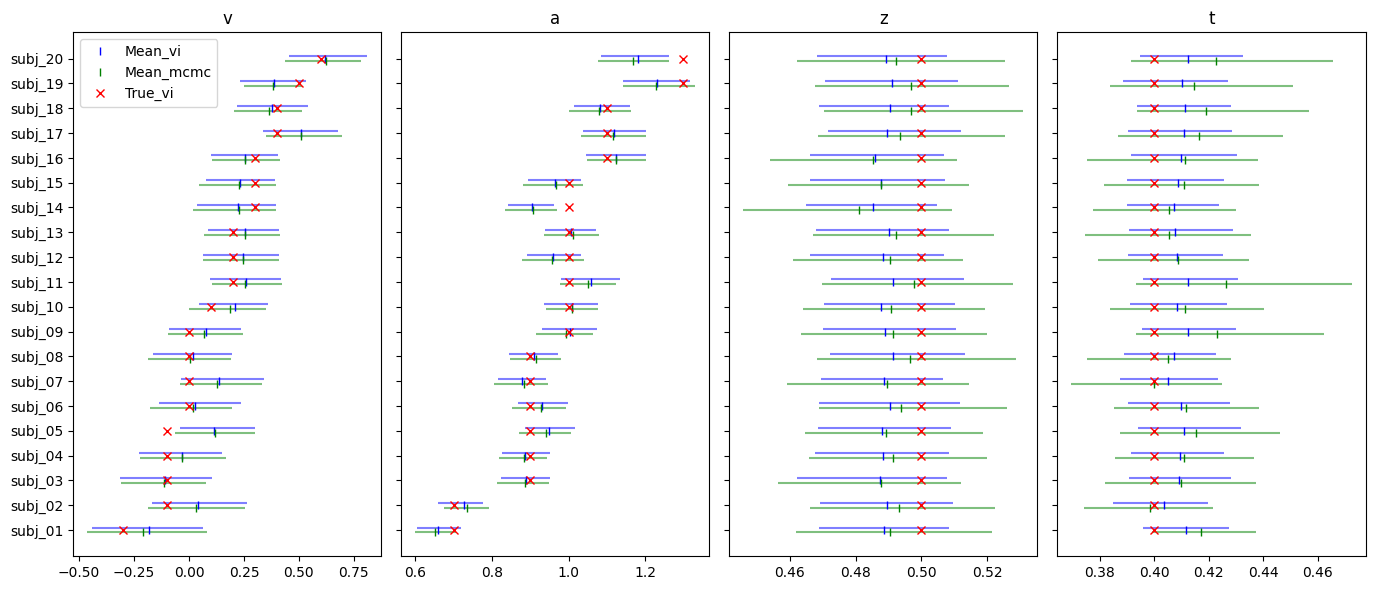

In [20]:
# Suppose your dataframe is called `df`
params = hssm.defaults.default_model_config["ddm"]["list_params"]
fig, axes = plt.subplots(nrows=1, ncols=len(params), figsize=(14, 6), sharey=True)

for ax, par in zip(axes, params):
    # Identify the relevant columns for this parameter
    mean_col = f"{par}_mean"
    lower_col = f"{par}_lower_hdi"
    upper_col = f"{par}_higher_hdi"
    true_col = f"{par}_true"  # if you also want to plot 'true' values

    # Sort if you want the participants in order on the y‐axis
    df_sorted_vi_nc = plot_df_vi_nc.sort_values("participant_id")
    df_sorted_mcmc_nc = plot_df_mcmc_nc.sort_values("participant_id")

    # We'll use the row index (0..N-1) for plotting against x=mean
    yvals = np.array(range(len(df_sorted_vi_nc)))
    yvals_vi = yvals + 0.1
    yvals_mcmc = yvals - 0.1

    # Draw horizontal lines from lower_HDI to upper_HDI
    ax.hlines(
        yvals_vi,
        df_sorted_vi_nc[lower_col],
        df_sorted_vi_nc[upper_col],
        color="blue",
        alpha=0.5,
    )

    ax.hlines(
        yvals_mcmc,
        df_sorted_mcmc_nc[lower_col],
        df_sorted_mcmc_nc[upper_col],
        color="green",
        alpha=0.5,
    )

    # Mark the posterior mean in blue
    ax.plot(
        df_sorted_vi_nc[mean_col],
        yvals,
        "|",
        color="blue",
        label="Mean_vi" if par == "v" else None,
    )
    ax.plot(
        df_sorted_mcmc_nc[mean_col],
        yvals_mcmc,
        "|",
        color="green",
        label="Mean_mcmc" if par == "v" else None,
    )

    # Optionally, if you have true values, plot them as red 'x'
    if true_col in df_sorted_vi_nc.columns:
        ax.plot(
            df_sorted_vi_nc[true_col],
            yvals,
            "x",
            color="red",
            label="True_vi" if par == "v" else None,
        )

    ax.set_title(par)
    ax.set_yticks(yvals)
    ax.set_yticklabels(df_sorted_vi_nc["participant_id"])
    ax.invert_yaxis()  # optional, if you prefer subject_01 at the top
    if par == "v":
        ax.legend()

plt.tight_layout()
plt.show()

Overall posteriors look very similar between the two approaches again. However, we can see that the MCMC posteriors are more variable than the VI posteriors in this case.
This illustrates a case where VI posteriors are too confident, and bayesian t-tests on parameter differences may yield different results when using the MCMC vs. the VI posteriors.
From a practical perspective, it is sometimes simply infeasible to run MCMC, while VI is still computationally tractable. In such cases we have to take what we can get...

